This is 2-qubit implementation of Grover algorithm

From https://www.amazon.com/Dancing-Qubits-quantum-computing-change/dp/1838827366
Chapter 9

1. Hidden number N
2. Number of qubits n in Z such that $ N <= 2^n $
3. A mapping from  data item to basis ket like $\vert j \rangle_n$
4. Construct oracle $f$ and gate/matrix $U_f$
5. Run $U_fU_\phi$ curcuit $\sqrt N$ times
6. Measure and read ket for hidden item
7. Repeat if not correct. Error is $O(1/N)$

### Create initial circuit of N input qubits

In [15]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

qubits = 2
def create_curcuit(qubits):
    input = QuantumRegister(qubits, name='input')
    output = QuantumRegister(1, name='output')
    classical = ClassicalRegister(2)

    qc = QuantumCircuit(input, output, classical)

    for i in range(qubits):
        qc.h(i)
    qc.x(qubits)
    return qc

qc = create_curcuit(qubits)
qc.draw()

┌───┐
 input_0: ┤ H ├
          ├───┤
 input_1: ┤ H ├
          ├───┤
output_0: ┤ X ├
          └───┘
   c13_0: ═════
               
   c13_1: ═════

### Place Oracle

In [16]:
hidden = '01'

def place_oracle(qc, hidden):
    from qiskit.circuit.library.standard_gates.x import XGate
    [qc.x(index) for (index, bit) in zip(range(len(hidden)), hidden) if not int(bit)]
    qc.ccx(0, 1, 2)
    [qc.x(index) for (index, bit) in zip(range(len(hidden)), hidden) if not int(bit)]

qc = create_curcuit(qubits)
qc.barrier()
place_oracle(qc, hidden)

qc.draw()

┌───┐ ░ ┌───┐     ┌───┐
 input_0: ┤ H ├─░─┤ X ├──■──┤ X ├
          ├───┤ ░ └───┘  │  └───┘
 input_1: ┤ H ├─░────────■───────
          ├───┤ ░      ┌─┴─┐     
output_0: ┤ X ├─░──────┤ X ├─────
          └───┘ ░      └───┘     
   c14_0: ═══════════════════════
                                 
   c14_1: ═══════════════════════

### Place Grover diffusion operator
$U_\phi = 2 \vert\phi\rangle\langle\phi\vert - I_2^n$

In [17]:
def place_grover(qc, qubits):
    qc.h(range(qubits))
    qc.x(range(qubits))
    qc.h(qubits-1)
    qc.cx(0, 1)
    qc.h(qubits-1)
    qc.x(range(qubits))
    qc.h(range(qubits))

def full_grover(hidden):
    qc = create_curcuit(qubits)
    qc.barrier()
    place_oracle(qc, hidden)
    qc.barrier()
    place_grover(qc, qubits)
    qc.measure([0,1], [0,1])
    return qc

qc = full_grover(hidden)
qc.draw()

┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌───┐          ┌───┐┌───┐     ┌─┐   
 input_0: ┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────┤M├───
          ├───┤ ░ └───┘  │  └───┘ ░ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐└╥┘┌─┐
 input_1: ┤ H ├─░────────■────────░─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫─┤M├
          ├───┤ ░      ┌─┴─┐      ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║ └╥┘
output_0: ┤ X ├─░──────┤ X ├──────░─────────────────────────────────────╫──╫─
          └───┘ ░      └───┘      ░                                     ║  ║ 
   c15_0: ══════════════════════════════════════════════════════════════╩══╬═
                                                                           ║ 
   c15_1: ═════════════════════════════════════════════════════════════════╩═

### Grover results for hidden string '11'

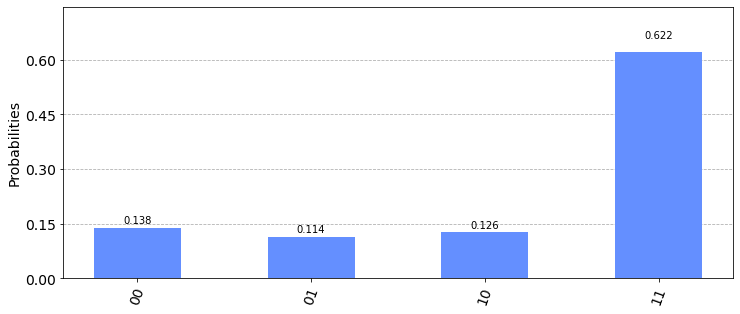

In [18]:
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram

# Execute experiment
backend = Aer.get_backend('qasm_simulator')
qc = full_grover('11')
result = execute(qc, backend).result()
counts = result.get_counts()

plot_histogram(counts,  figsize=(12, 5))

## Additional resources

1. https://demonstrations.wolfram.com/QuantumCircuitImplementingGroversSearchAlgorithm/
2. https://github.com/Qiskit/qiskit-aqua/blob/master/qiskit/aqua/algorithms/amplitude_amplifiers/grover.py